In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

from sklearn.decomposition import *

<br>

# Description of PCA
---

<br> 

### The principle

We have a design matrix $X$ (each of the $n$ row is a data point of dimension $d$) of dimension $\mathcal{R}^{n \times d}$. We look for a transformation of the inputs from dimension $d$ to dimension $m$, such that $m \ll d$, but we keep most of the information of the data.

The **manifold hypothesis** states that most of the data lies a lower dimension sub-space. If we further consider this sub-space to be an hyperplane of the original space, PCA can be used. The goal is to identify the **sub-space along which we have most variance**. Why? Because it is the signature of the manifold we are looking for: no variances along the other axis thare are not used.

We therefore look for a linear transformation $W$ of dimension $\mathcal{R}^{d \times m}$:

* The new data will be $T = XW$ of dimension $\mathcal{R}^{n \times m}$
* The new features will be ordered by decreasing variance along the dimension

Recall that matrix multiplication is:

&emsp; $T_{ij} = (XW)_{ij} = row(X,i)^T col(W,j)$
&emsp; $\implies$
&emsp; $T_{ij} = x_i^T w_j$
&emsp; where
&emsp; $W = (w_1, w_2 \dots w_m)$

We therefore see that **the vectors $w_i$ are selected vectors of dimension $d$ in the original space along which the data $X$ will be projected.**

<br>

### Alternative definition

An alternate definition that might help getting a different point of view on PCA, is to see PCA as a way to minimize the squared distance between a point and its projection on the selected sub-space of dimension $M < D$.

Let us consider an orthonomal basis $U = (u_1, \dots u_D)$ of the original space of $X$. Let us consider without loss of generality the sub-space of dimension $M < D$ spawn by the vectors $W = (u_1, \dots u_M)$. We can decompose each data point $x_n$ and its approximation $\tilde{x}_n$ as:

&emsp; $\displaystyle x_n = \sum_{i=1}^{D} \{ x_n^T u_i \} u_i$
&emsp; $\implies$
&emsp; $\displaystyle \tilde{x}_n = \sum_{i=1}^{M} \{ x_n^T u_i \} u_i + \sum_{i>M}^D b_i u_i$
&emsp; (where $b_i$ are constants not depending on $x_n$)

Our goal is to minimize the square distance between the points and their approximation, for which we can solve for the coordinates of the vectors $\tilde{x}_n$ and parameters $b_i$ by setting the partial derivative to zero:

&emsp; $\displaystyle J = \frac{1}{N} \sum_n \Vert x_n - \tilde{x}_n \Vert^2$
&emsp; $\implies$
&emsp; $\tilde{x}_{ni} = x_{ni}$ (for $i \le M$)
&emsp; and
&emsp; $b_i = \bar{x}_i$ (for $i > M$)

Injecting these results back into the definition of the error $J$, we get an expression the error that corresponds to the covariance of the data point when projected on the completement of sub-space $W$, $W_c = (u_{M+1}, \dots u_D)$:

&emsp; $\displaystyle J = \frac{1}{N} \sum_{n=1}^N \sum_{i>M}^D (x_{ni} - \bar{x}_i)^2$

This leads us to searching the set of vectors $(u_{M+1}, \dots u_D)$ that minimize the variance, exactly the complement of what we were searching in our previous formulation of PCA. The result is exactly the same.

<br>

### How to proceed - general idea

We can proceed recursively:

1. Identify the axis (vector $w_1$) along which the data has the most variance
2. Project the data $X$ to this axis ($X w_1$ will given the first column of the new matrix $T$)
3. Remove this projection to all data point (so next $w_i$ are orthogonal to previous $w_{j<i})$
4. Recurse (try to find the next dimension with the most variance)

The variance of a data set is given by (assuming $X$ is centered on zero):

&emsp; $\sigma^2[X] = \frac{1}{N} \sum_n x_n x_n^T = \frac{1}{N} X^T X = S$
&emsp;
&emsp; (with $S$ symmetric and positive definite)

The variance along one dimension is simply:

&emsp; $\sigma^2[X w_i] = \frac{1}{N} \sum_n (x_n^T w_i)^T (x_n^T w_i) = \frac{1}{N} \sum_n w_i^T x_n x_n^T w_i = w_i^T S w_i$

We know that $S$ is symmetric and definite positive. This implies that $S$ has positive real eigenvalues. We can simply **align $w_i$ with the eigenvector associated to the highest eigenvalue**. It is easy to see that this is the best axis we can select.

We can derive the same result (the fact that $w_i$ needs to be an eigenvector) differently, by using constraint optimization. We build a Langrangian $\mathcal{L}$ to encode the constraint that $w_i$ should be a unit vector, and maximize this value:

&emsp; $\mathcal{L}(w,\lambda) = w^T S w - \lambda (w^T w - 1)$
&emsp; $\implies$
&emsp; $\displaystyle \frac{\partial \mathcal{L}}{\partial w} = S w - \lambda w = 0$
&emsp; $\implies$
&emsp; $S w = \lambda w$
&emsp; ($w$ is an eigenvector)

The general idea is therefore the following: do the eigen decomposition of the covariance matrix $S$ and pick the eigen vectors corresponding to the highest eigen values. The resulting values $t_n^T = x_n^T W$ will correspond to the projections of $x_n$ with the highest remaining variance (and therefore by assumption, with the most information).

<br>

### First algorithm (eigen decomposition of the covariance matrix)

Compute $S = X^T X$ and decomposite it in eigen values $S = V \Lambda V^T$ where $V = (v_1, \dots v_n)$ are the orthogonal eigenvectors of $S$.

We now pick a sub-selection of the $m < d$ eigenvectors of size $d$ of $V$ to form a matrix $W$. We pick these vectors such that their eigen values are maximum. The new data is obtained by multiplying the design matrix $X$ by $W$, which means projecting the data along these selected axis:

&emsp; $T = XW \in \mathcal{R}^{p \times l}$

**Side note:** the expression $S = V \Lambda V^T$ can be reworked as $V^T X^T X V = \Lambda = (X V)^T X V = T^T T$. So we see that there exists an orthogonal transformation $T = XV$ such that each axis is independent (no covariance).

**Important note:** The covariance only find linear (not even affine) relationships. This means the data must be centered in order for it to work. It also means that each axis is **independent for linear relationships** (it does not work for other kind of relationships).

In [61]:
# Simple example with clearly correlated features
X = np.array([
    [-1., 2.],
    [ 0., 0.],
    [ 1, -2.]])

# Remove the mean
X = X - np.mean(X, axis=0, keepdims=True)

# Decompose the covariance matrix
eigen_values, eigen_vectors = np.linalg.eig(X.T @ X)

# Sort the eigen values by descending eigen values, and keep the first
descending_indices = np.argsort(eigen_values)[::-1]
W = eigen_vectors[:,descending_indices[:1]]

# Project the data in this new space
T = X @ W
print(T)

# Alternatively, we could use Scikit-learn to do this for us
pca = PCA(n_components=1)
print(pca.fit_transform(X))

[[-2.23606798]
 [ 0.        ]
 [ 2.23606798]]
[[-2.23606798]
 [ 0.        ]
 [ 2.23606798]]


<br>

### Second algorithm (SVD decomposition)

All matrices can be decomposed like $X = U \Sigma V^T$ where $V$ are the orthogonal eigenvectors of $X^T X$, $U$ are the orthogonal eigenvectors of $X X^T$, and $\Sigma$ is a diagonal matrix (stretching matrix) of **singular values** where $\lambda_i = \sigma_i^2$ are the eigenvalues of $X^T X$.

So we can use SVD decomposition, and sort the singular values in decreasing order, and then select the $m < d$ eigenvectors associated to the highest eigenvalues of $V$ to create $W$.

In [14]:
# Compute the svd decomposition of X
u, s, v_t = np.linalg.svd(X)

# Sort the eigen values by descending eigen values, and keep the first
descending_indices = np.argsort(s)[::-1]
W = v_t.T[:,descending_indices[:1]]

# Print the transformed matrix
T = X @ W
print(T)

[[-2.23606798]
 [ 0.        ]
 [ 2.23606798]]


<br>

### High dimensional data

When the dimension of the data is higher than the number of samples ($D > N$), we can improve the computational efficiency of PCA. The covariance matrix $X^T X$ is much more expensive to compute than the similarity (or kernel) matrix $X X^T$ which is also symmetric and can be used instead to compute the eigenvectors of $X^T X$:

&emsp; $X^T X v_i = \lambda_i v_i$
&emsp; $\implies$
&emsp; $X X^T X v_i = \lambda_i X v_i$
&emsp; $\implies$
&emsp; $X v_i$ is an eigenvector of $X X^T$ with same eigenvalue $\lambda_i$

&emsp; $X X^T u_i = \lambda_i u_i$
&emsp; $\implies$
&emsp; $X^T X X^T u_i = \lambda_i X^T u_i$
&emsp; $\implies$
&emsp; $X^T u_i$ is an eigenvector of $X^T X$ with same eigenvalue $\lambda_i$

The same can be rephrased with matrices:

&emsp; $X^T X V = V \Lambda$
&emsp; $\implies$
&emsp; $X X^T X V = X V \Lambda$
&emsp; $\implies$
&emsp; $X V$ are the eigenvectors of $X X^T$ with same eigenvalues $\Lambda$

&emsp; $X X^T U = U \Lambda$
&emsp; $\implies$
&emsp; $X^T X X^T U = X^T U \Lambda$
&emsp; $\implies$
&emsp; $X^T U$ are the eigenvectors of $X^T X$ with same eigenvalues $\Lambda$

This lead us to the following algorithm:

1. compute the eigen decomposition of $X X^T = U \Lambda U^T$
2. select the sub-set $W_U$ of the column vectors of $U$ corresponding to the highest eigenvalues
3. the sub-set $W$ of the eigen vectors of $V$ is obtained by $W = X^T W_U$
4. normalize the vectors of $W$ (they will not be because of multipication by $X^T$)
5. transform the inputs via $T = X W$

In [166]:
# Simple example with clearly correlated features
X = np.array([
    [-1., 2., 4., -2., -3],
    [1., -2., -4., 2., 3.],
    [2., -4., -8., 4., 6.]])

# Remove the mean
X = X - np.mean(X, axis=0, keepdims=True)

# Decompose the covariance matrix
eigen_values, eigen_vectors = np.linalg.eig(X @ X.T)

# Sort the eigen values by descending eigen values, and keep the first
descending_indices = np.argsort(eigen_values)[::-1]
W_U = eigen_vectors[:,descending_indices[:1]]

# Compute the eigen values of X^T X (and normalize them)
W = X.T @ W_U
W /= np.linalg.norm(W, axis=0, keepdims=True)

# Project the data in this new space
T = X @ W
print(T)

# Alternatively, we could use Scikit-learn to do this for us
pca = PCA(n_components=1)
print(pca.fit_transform(X))

[[-9.71825316]
 [ 1.94365063]
 [ 7.77460253]]
[[ 9.71825316]
 [-1.94365063]
 [-7.77460253]]


<br>

### Kernel PCA

We just saw that we can rework PCA to perform an eigen decomposition of the similarity matrix $X X^T$ rather than the covariance matrix $X^T X$. This allows to deal with data sets where the dimensionality $D$ is much larger than $N$.

We can extend this to deal projections $\phi$ from our original space of size $D$ to infinite dimensional target space. The trick is to never compute $\phi(x)$ but to compute the dot product of the projection of two vectors $k(x,y) = \phi(x)^T \phi(y)$. We can check how we can always end up avoiding projections with $\phi$, starting with the kernel matrix $K$:

&emsp; $K = X X^T$
&emsp; $\implies$
&emsp; $K_{ij} = x_i^T x_j$
&emsp; which we can replace by
&emsp; $K_{ij} = \phi(x_i)^T \phi(x_j) = k(x_i, x_j)$

Then the eigenvectors $v_i$ are linear combinations of the $\phi(x_n)$. We cannot have more than $N$ eigenvectors because we have at most $N$ values.. Similarly, the projections $\Phi(x)$ of new points $\phi(x)$ will be compressed by projecting to the selected eigenvectors $v_i$:

&emsp; $\displaystyle v_i = \sum_{n=1}^N v_{in} \phi(x_n)$
&emsp; $\displaystyle \phi(x) = \sum_{i=1}^M \phi(x)_i v_i = \sum_{i=1}^M \{ \phi(x)^T v_i \} v_i$
&emsp; $\implies$
&emsp; $\displaystyle \phi(x)_i = \sum_{n=1}^N v_{in} \phi(x)^T \phi(x_n) = \sum_{n=1}^N v_{in} k(x,x_n)$

We can therefore compute the matrix $V$ of eigenvectors based on $K$ and compute the image of any point $x$ by only using the kernel:

&emsp; $T = W^T \begin{pmatrix} k(x,x_1) \\ \vdots \\ k(x,x_n) \end{pmatrix} = \big ( k(x,x_1) \dots k(x,x_n) \big ) W$
&emsp; where $W$ are a sub-set of the eigen vectors $V$ of $K$

**Note:** this is equivalent to the previous work formula we derived for high dimensional data:

&emsp; $T = X W$ where $W = X^T W_U$ and $W_U$ are eigenvectors of $X X^T$
&emsp; $\implies$
&emsp; $\boxed{t^T = x^T W = x^T X^T W_U}$

We can see that $x^T X^T$ corresponds to $\big ( k(x,x_1) \dots k(x,x_n) \big )$ and $W_U$ corresponds to the eigenvectors of the kernel matrix $K$.

In [187]:
# Simple example with clearly correlated features
X = np.array([
    [-1., 2., 4., -2., -3],
    [1., -2., -4., 2., 3.],
    [2., -4., -8., 4., 6.]])
N, D = X.shape

# Remove the mean
X = X - np.mean(X, axis=0, keepdims=True)

# Simple kernel to show the equivalence
def kernel(x, y):
    return np.dot(x, y)

K = np.array([[kernel(X[i], X[j]) for j in range(N)] for i in range(N)])

# Decompose the kernel matrix
eigen_values, eigen_vectors = np.linalg.eigh(K)

# Sort the eigen values by descending eigen values, and keep the first
descending_indices = np.argsort(eigen_values)[::-1]
W = eigen_vectors[:,descending_indices[:1]]
print(W)

# Project the data in this new space
def project(xs):
    kx = np.array([[kernel(x, y) for y in X] for x in xs])
    return kx @ W

print(project(X))

[[ 0.77151675]
 [-0.15430335]
 [-0.6172134 ]]
[[122.41399097]
 [-24.48279819]
 [-97.93119278]]


<br>

### Reconstruction of the original data

The compressed data $T = XW$ is useful in itself in case we want to do machine learning: just insert the transformation in your data pipeline and then apply your favorite machine learning algorithm. In some instances though, we are interested in visualizing or reconstructing the orginal data $X$ from the compressed version $T$.

The key is to consider that the transformation $T = XW$ is similar to the transformation $T = XV$ where the additional columns of $V$ compared to $W$ are replaced with 0. The full reconstruction would be $T V^T = X$, the lossy reconstruction is therefore $X = T W^T$.

In [73]:
# Simple example with clearly correlated features
X = np.array([
    [-1., 2.],
    [ 0., 0.],
    [ 1, -2.]])

# Remove the mean
X = X - np.mean(X, axis=0, keepdims=True)

# Decompose the covariance matrix
eigen_values, eigen_vectors = np.linalg.eig(X.T @ X)

# Sort the eigen values by descending eigen values, and keep the first
descending_indices = np.argsort(eigen_values)[::-1]
W = eigen_vectors[:,descending_indices[:1]]

# Project the data in this new space
T = X @ W
print(T)

# Reconstruct the data
print(T @ W.T)

[[-2.23606798]
 [ 0.        ]
 [ 2.23606798]]
[[-1.  2.]
 [ 0.  0.]
 [ 1. -2.]]


<br>

# Example: MNIST
---

In [193]:
from PIL import Image
import torchvision

training_data_set = torchvision.datasets.MNIST('./dataset/mnist/training.pt', train=True, download=True)
test_data_set = torchvision.datasets.MNIST('./dataset/mnist/test.pt', train=False, download=True)

images = [training_data_set[i][0] for i in range(len(training_data_set))]
pipeline = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
X = np.stack([pipeline(image) for image in images])
X = X.reshape((60000, -1))
X.shape

(60000, 784)

<br>

### PCA on MNIST

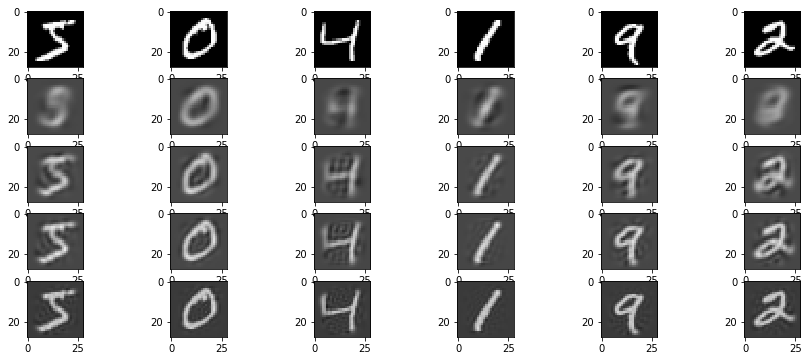

In [153]:
dimensions = [10, 50, 100, 200]
results = []
for d in dimensions:
    pca = PCA(n_components=d)
    X2 = pca.inverse_transform(pca.fit_transform(X))
    X2 = X2.reshape((60000, 28, 28))
    span = X2.max() - X2.min()
    X2 = (X2 - X2.min()) / span
    results.append(X2)

def to_image(x):
    return Image.fromarray(np.uint8(x*255), 'L')

n_cols=6
_, ax = plt.subplots(figsize=(15,6), ncols=n_cols, nrows=len(results)+1)
for i in range(n_cols):
    ax[0][i].imshow(images[i])
    for j, r in enumerate(results):
        ax[j+1][i].imshow(to_image(r[i]))
plt.show()

<br>

### Auto-encoders on MNIST

In [225]:
class AutoEncoder(nn.Module):
    def __init__(self, hidden_size: int, hidden_level: int, latent_size: int):
        super().__init__()
        self.encoder_conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=2, out_channels=4, kernel_size=3, stride=1))

        self.relu = nn.ReLU()
        
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=4, out_channels=2, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=2, out_channels=1, kernel_size=3, stride=1))
        
        encoder_stack = []
        decoder_stack = []
        for stack in encoder_stack, decoder_stack:
            for _ in range(hidden_level):
                stack.append(nn.Linear(hidden_size, hidden_size))
                stack.append(nn.ReLU())
        
        input_size = self.conv_out()
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            *encoder_stack,
            nn.Linear(hidden_size, latent_size))
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),
            *decoder_stack,
            nn.Linear(hidden_size, input_size))
        
    def conv_out(self):
        out = self.encoder_conv(torch.zeros(4, 1, 28, 28))
        _, out_size = out.reshape((4, -1)).shape
        return out_size
    
    def forward(self, xs):
        batch_size, _ = xs.shape
        xs = xs.reshape((batch_size, 1, 28, 28))
        xs = self.encoder_conv(xs)
        xs = xs.reshape((batch_size, -1))
        xs = self.relu(xs)
        zs = self.encoder(xs)
        ys = self.decoder(zs)
        ys = self.relu(ys)
        ys = ys.reshape((batch_size, 4, 24, 24))
        ys = self.decoder_conv(ys)
        return ys.reshape((batch_size, -1))


def train(model: AutoEncoder, epoch_nb: int):
    model.train()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters())
    ds = data.TensorDataset(torch.FloatTensor(X))
    loader = data.DataLoader(ds, shuffle=True, batch_size=100)
    for epoch in range(epoch_nb):
        episode_loss = 0.
        for [x] in loader:
            y = model(x)
            loss = criterion(y, x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            episode_loss += loss.item()
        print("Epoch", epoch+1, ":", episode_loss)


model = AutoEncoder(hidden_size=256, hidden_level=1, latent_size=10)
train(model, epoch_nb=10)

Epoch 1 : 24.928337981924415
Epoch 2 : 12.72038864903152
Epoch 3 : 10.699945354834199
Epoch 4 : 9.7328882496804
Epoch 5 : 9.09023199416697
Epoch 6 : 8.597966860048473
Epoch 7 : 8.207291519269347
Epoch 8 : 7.905685813166201
Epoch 9 : 7.685559114441276
Epoch 10 : 7.470884793438017


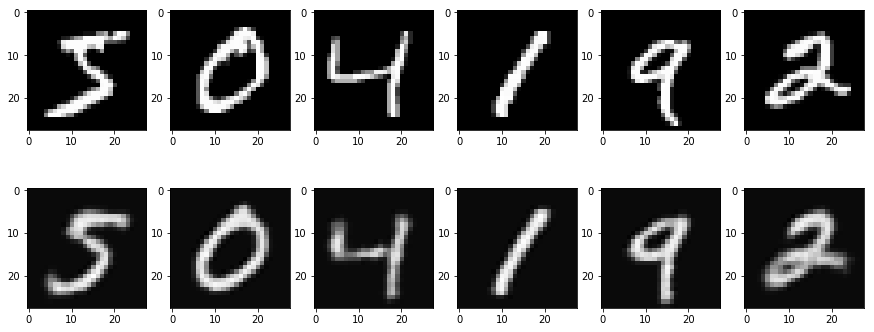

In [226]:
def evaluate(model: AutoEncoder, X):
    model.eval() 
    return model(torch.FloatTensor(X)).detach().numpy()


n_cols=6

Y = evaluate(model, X[:n_cols])
Y = Y.reshape((n_cols, 28, 28))
span = Y.max() - Y.min()
Y = (Y - Y.min()) / span

_, ax = plt.subplots(figsize=(15,6), ncols=n_cols, nrows=2)
for i in range(n_cols):
    ax[0][i].imshow(images[i])
    ax[1][i].imshow(to_image(Y[i]))
plt.show()

<br>

# Whitening: PCA to normalize
---

We can use PCA to normalize the data and remove covariance. This might help with some algorithms such as K-means (but it also might break K-means, which is very sensitive to scaling).

<br>

# Limits of PCA
---

The naive PCA is computationally intensive (due to the eigen value decomposition and the matrix multiplication to get the covariance matrix).

PCA is limited to find linear relationships, due to the definition of covariance between two variables: $E[(X_i - \bar{X_i})(X_j - \bar{X_j})]$ and more generally the fact that we work with linear functions (eigen vectors, orthogonal rotation matrix).

**Example:**

* In polar coordinates $\rho e^{i\theta}$, the data has low variance for $\rho$, but high variance for $\theta$
* If we had to keep an axis, it would be the axis for $\theta$, but in the cartesian coordinates, PCA cannot do this

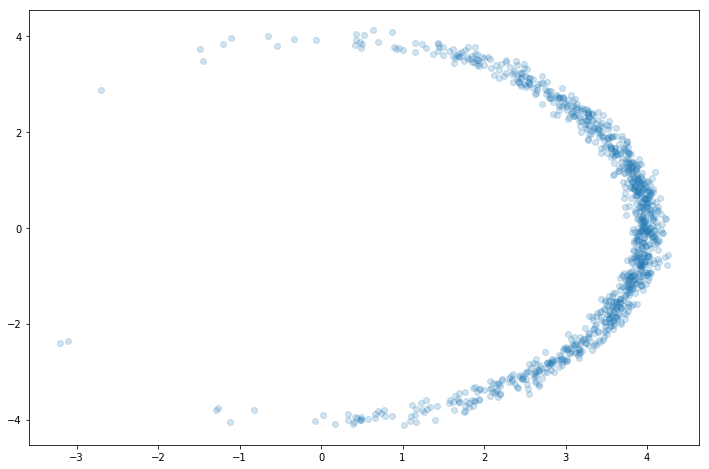

In [4]:
polars = np.random.multivariate_normal(
    mean=np.array([4.0, 0.0]),
    cov=np.array([[0.01, 0.0], [0.0, 0.5]]),
    size=1000)

def transform(cluster):
    xs = cluster[:,0] * np.cos(cluster[:,1])
    ys = cluster[:,0] * np.sin(cluster[:,1])
    return np.concatenate([np.expand_dims(xs, -1), np.expand_dims(ys, -1)], axis=1)

X = transform(polars)

plt.figure(figsize=(12, 8))
plt.scatter(X[:,0], X[:,1], alpha=0.2)
plt.show()

We can lift this limitations by first transforming our data into another vector space that makes the relations between variable appear linear. This is typically done by projecting in higher dimensions.

Here we illustrate what it does with a transformation from cartesian coordinates back to polar coordinates (so that it stays in 2D and is drawable), but in the general case:

1. we do not know which transformation to apply
2. we do not care about the reverse projection

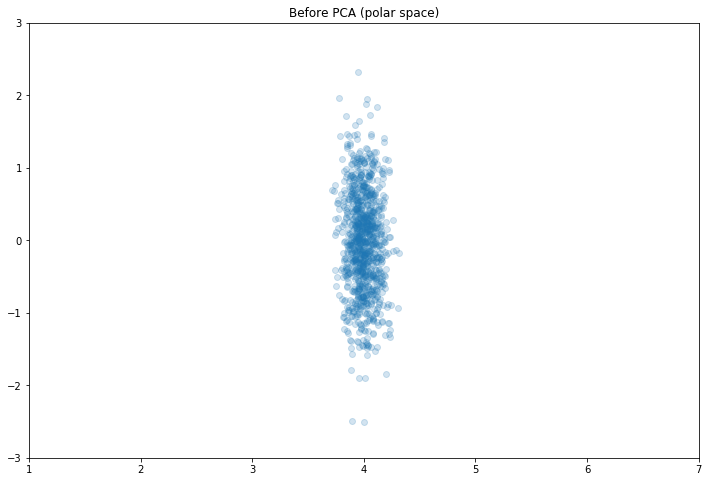

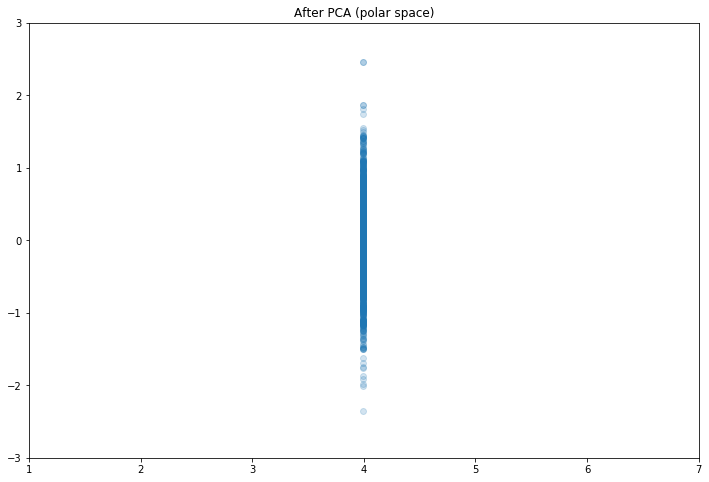

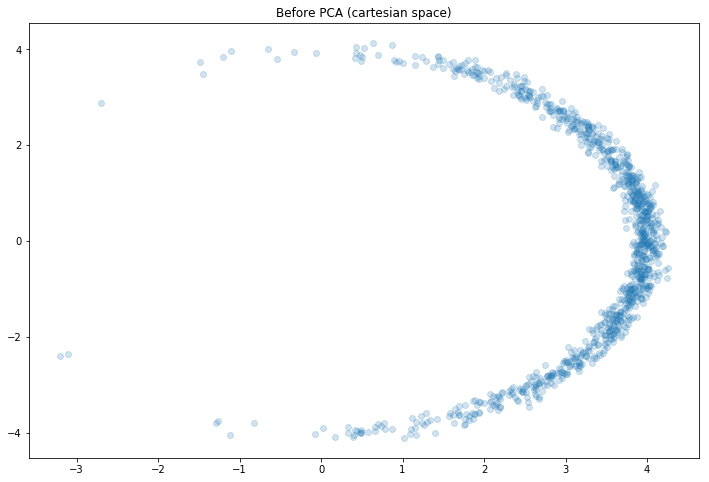

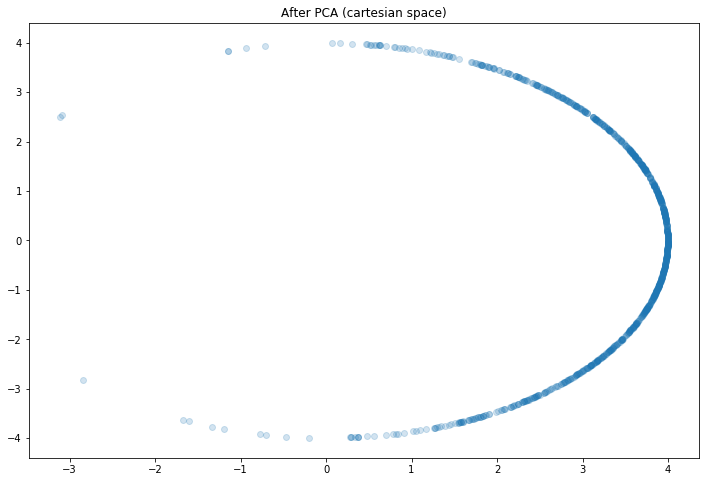

In [5]:
# The projection in different space
def project(cluster):
    norms = np.sqrt(cluster[:,0] ** 2 + cluster[:,1] ** 2)
    theta = np.arctan2(cluster[:,1], cluster[:,0])
    return np.concatenate([np.expand_dims(norms, -1), np.expand_dims(theta, -1)], axis=1)
    

# Show the result of the projection
T = project(X)
plt.figure(figsize=(12, 8))
plt.scatter(T[:,0], T[:,1], alpha=0.2)
plt.xlim(1, 7)
plt.ylim(-3, 3)
plt.title("Before PCA (polar space)")
plt.show()


# Remove the means in the projected space
feature_means = np.mean(T, axis=0)
T = T - feature_means


# Extract the principal components
pca = PCA(n_components=1)
T2 = pca.fit_transform(T)

plt.figure(figsize=(12, 8))
plt.scatter(np.full(fill_value=feature_means[0], shape=T2.shape), feature_means[1] + T2, alpha=0.2)
plt.xlim(1, 7)
plt.ylim(-3, 3)
plt.title("After PCA (polar space)")
plt.show()


# Show the result on the main space
X2 = transform(np.concatenate([np.full(fill_value=feature_means[0], shape=T2.shape), feature_means[1] + T2], axis=1))

plt.figure(figsize=(12, 8))
plt.scatter(X[:,0], X[:,1], alpha=0.2)
plt.title("Before PCA (cartesian space)")
plt.show()

plt.figure(figsize=(12, 8))
plt.scatter(X2[:,0], X2[:,1], alpha=0.2)
plt.title("After PCA (cartesian space)")
plt.show()

**Important notes:**
* the graphical illustrations are in 2D here in order to explain visually the effect of PCA, but in reality, one of the dimension has been completely removed (and we just have 1D)
* the alignment along the directions of the axis here is not necessary: PCA will find rotations if necessary

<br>

# Example: Kernel PCA
---

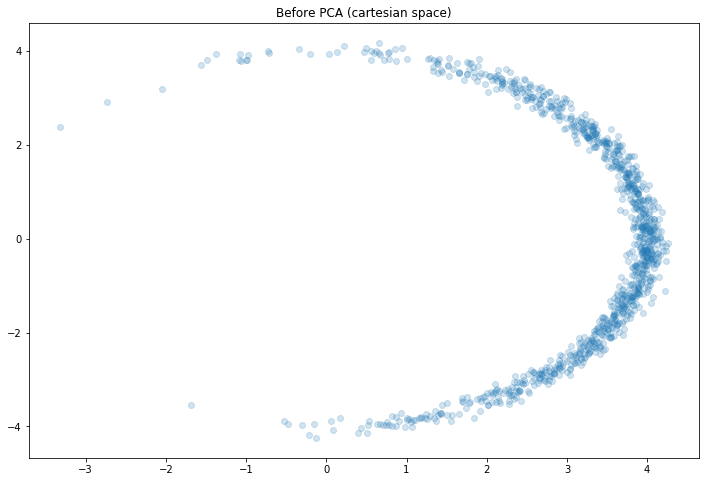

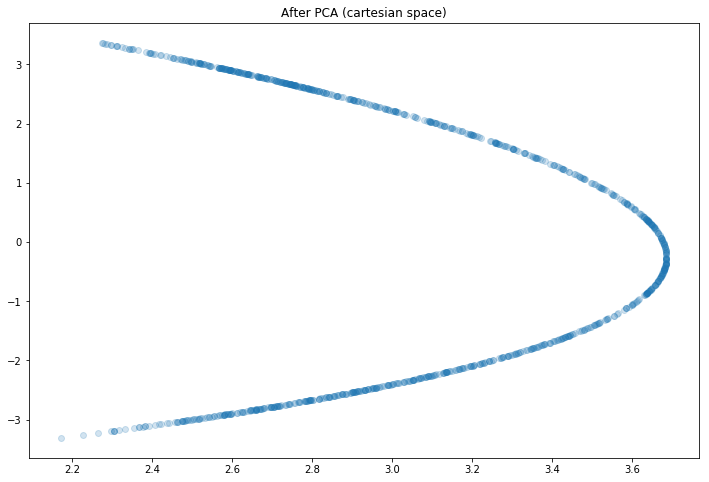

In [6]:
polars = np.random.multivariate_normal(
    mean=np.array([4.0, 0.0]),
    cov=np.array([[0.01, 0.0], [0.0, 0.5]]),
    size=1000)

def transform(cluster):
    xs = cluster[:,0] * np.cos(cluster[:,1])
    ys = cluster[:,0] * np.sin(cluster[:,1])
    return np.concatenate([np.expand_dims(xs, -1), np.expand_dims(ys, -1)], axis=1)

X = transform(polars)

pca = KernelPCA(kernel='poly', n_components=1, fit_inverse_transform=True)
T = pca.fit_transform(X)

X2 = pca.inverse_transform(T)

plt.figure(figsize=(12, 8))
plt.scatter(X[:,0], X[:,1], alpha=0.2)
plt.title("Before PCA (cartesian space)")
plt.show()

plt.figure(figsize=(12, 8))
plt.scatter(X2[:,0], X2[:,1], alpha=0.2)
plt.title("After PCA (cartesian space)")
plt.show()

Now, there is a degradation that we can witness when we reconstruct the data.

However, PCA is often used as a first dimensionality reduction technique in order to solve a specific task. Ultimately, the quality of the transformation / dimensionnality reduction can only be assessed by checking whether or not the task we are interested in is still solvable with the same accuracy after the transformation.

<br>

# Auto-encoders
---

Link with compression

Link with latent variables?

810.5705157220364
326.3637037947774
74.18648477550596
23.927642543334514
12.537722812616266
8.19772295479197
6.366098614642397
5.0810425283852965
4.400423057260923
3.6655066144885495
3.2390874541015364
3.1622666367329657
2.8923043975955807
2.5605268724029884
2.5148760015144944


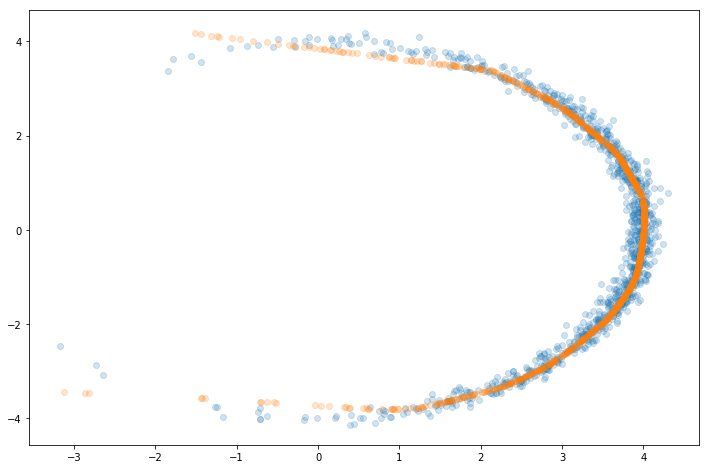

In [17]:
polars = np.random.multivariate_normal(
    mean=np.array([4.0, 0.0]),
    cov=np.array([[0.01, 0.0], [0.0, 0.5]]),
    size=1000)

def transform(cluster):
    xs = cluster[:,0] * np.cos(cluster[:,1])
    ys = cluster[:,0] * np.sin(cluster[:,1])
    return np.concatenate([np.expand_dims(xs, -1), np.expand_dims(ys, -1)], axis=1)

X = transform(polars)


class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1))
        self.decoder = nn.Sequential(
            nn.Linear(1, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 2))
    
    def forward(self, xs):
        return self.decoder(self.encoder(xs))
    
    def encode(self, xs):
        return self.encoder(xs)
    
    def decode(self, xs):
        return self.decoder(xs)


model = AutoEncoder()

model.train()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters())
ds = data.TensorDataset(torch.FloatTensor(X))
loader = data.DataLoader(ds, shuffle=True, batch_size=5)

for _ in range(15):
    episode_loss = 0.
    for [x] in loader:
        y = model(x)
        loss = criterion(y, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        episode_loss += loss.item()
    print(episode_loss)


model.eval() 
Y = model(torch.FloatTensor(X)).detach().numpy()


plt.figure(figsize=(12, 8))
plt.scatter(X[:,0], X[:,1], alpha=0.2)
plt.scatter(Y[:,0], Y[:,1], alpha=0.2)
plt.show()